# An√°lise Estat√≠stica de Dados e Informa√ß√µes
**PPCA/UNB**

---

**Prova - Quest√£o 03**  
**Professor**: Jo√£o Gabriel de Moraes Sousa  
**Aluna**: Andreia Queiroz Correia Dummar  
**Matr√≠cula**: 241134680  
**Data da Entrega**: 09/02/2025  
**Github**: https://github.com/aqcorreia/AEDI/tree/main/Prova

---

**Aplica√ß√£o**: ANOVA (An√°lise de Vari√¢ncia)

**Dados**: Vendas de Varejo Online (https://www.kaggle.com/datasets/mathchi/online-retail-ii-data-set-from-ml-repository?select=online_retail_II.xlsx)

---

O dataset **Online Retail** cont√©m informa√ß√µes sobre transa√ß√µes de uma loja de com√©rcio eletr√¥nico sediada no Reino Unido. Ele registra detalhes das compras feitas por clientes entre **2009 e 2010**.

Cont√©m as seguintes colunas:

| **Coluna**        | **Descri√ß√£o** |
|------------------|--------------|
| `Invoice`       | N√∫mero da fatura da transa√ß√£o. |
| `StockCode`     | C√≥digo √∫nico do produto. |
| `Description`   | Nome ou descri√ß√£o do produto. |
| `Quantity`      | Quantidade de itens comprados na transa√ß√£o. |
| `InvoiceDate`   | Data e hora da compra. |
| `Price`         | Pre√ßo unit√°rio do produto. |
| `Customer ID`   | Identificador do cliente. |
| `Country`       | Pa√≠s do cliente. |

---

## 1) Bibliotecas

In [1]:
# Bibliotecas para manipula√ß√£o de dados
import pandas as pd
import numpy as np

# Bibliotecas para estat√≠sticas
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import normaltest

# Bibliotecas para visualiza√ß√£o
import matplotlib.pyplot as plt
import seaborn as sns

## 2) Fun√ß√µes

In [2]:
def verificar_valores_faltantes(df):
    """
    Fun√ß√£o para verificar valores faltantes em um DataFrame.

    Par√¢metros:
        df (pd.DataFrame): O DataFrame a ser analisado.

    Retorno:
        pd.DataFrame: DataFrame com as colunas, a quantidade de valores faltantes e o percentual correspondente.
    """
    # Contar valores faltantes por coluna
    valores_faltantes = df.isnull().sum()
    
    # Filtrar apenas colunas com valores faltantes (ignorar valores zero)
    valores_faltantes = valores_faltantes[valores_faltantes > 0]
    
    # Calcular o percentual de valores faltantes
    percentual_faltante = (valores_faltantes / len(df)) * 100
    
    # Criar DataFrame com as informa√ß√µes
    resultado = pd.DataFrame({
        'Coluna': valores_faltantes.index,
        'Valores Faltantes': valores_faltantes.values,
        'Percentual Faltante (%)': percentual_faltante.values
    })
    
    # Ordenar pelo n√∫mero de valores faltantes
    resultado = resultado.sort_values(by='Valores Faltantes', ascending=False).reset_index(drop=True)
    
    return resultado

In [3]:
def plot_boxplot(df, coluna_categorica, coluna_numerica):
    """
    Gera um boxplot para visualizar a rela√ß√£o entre uma vari√°vel categ√≥rica e uma vari√°vel num√©rica.

    Par√¢metros:
        df (pd.DataFrame): DataFrame contendo os dados.
        coluna_categorica (str): Nome da coluna categ√≥rica para o eixo X.
        coluna_numerica (str): Nome da coluna num√©rica para o eixo Y.
    """
    plt.figure(figsize=(20, 6))  # Ajusta o tamanho para melhor visualiza√ß√£o

    # Corre√ß√£o do FutureWarning: Definir explicitamente 'hue' e desativar a legenda
    sns.boxplot(x=coluna_categorica, y=coluna_numerica, hue=coluna_categorica, data=df, palette='coolwarm', legend=False)

    plt.xticks(rotation=90)  # Rotaciona os r√≥tulos para evitar sobreposi√ß√£o
    plt.title(f'{coluna_numerica} vs. {coluna_categorica}')
    plt.xlabel(coluna_categorica)
    plt.ylabel(coluna_numerica)

    plt.show()


In [4]:
def plot_media_confidence(df, coluna_categorica, coluna_numerica):
    """
    Gera um gr√°fico de m√©dias por categoria com intervalo de confian√ßa de 95%.
    
    Par√¢metros:
        df (pd.DataFrame): DataFrame contendo os dados.
        coluna_categorica (str): Nome da coluna categ√≥rica (eixo X).
        coluna_numerica (str): Nome da coluna num√©rica (eixo Y).
    """
    plt.figure(figsize=(15, 6))

    # Corre√ß√£o do FutureWarning: Substituindo ci pelo novo errorbar
    sns.pointplot(x=coluna_categorica, y=coluna_numerica, data=df, errorbar=('ci', 95), capsize=0.2, color='b')

    plt.xticks(rotation=90)
    plt.title(f'M√©dia de {coluna_numerica} por {coluna_categorica} (com intervalo de confian√ßa 95%)')
    plt.xlabel(coluna_categorica)
    plt.ylabel(f'M√©dia de {coluna_numerica}')

    plt.show()


In [5]:
def plot_violinplot(df, coluna_categorica, coluna_numerica):
    """
    Gera um Violin Plot para visualizar a distribui√ß√£o de uma vari√°vel num√©rica por categorias.

    Par√¢metros:
        df (pd.DataFrame): DataFrame contendo os dados.
        coluna_categorica (str): Nome da coluna categ√≥rica (eixo X).
        coluna_numerica (str): Nome da coluna num√©rica (eixo Y).
    """
    plt.figure(figsize=(15, 6))

    # Corre√ß√£o do FutureWarning: Adicionando hue e desativando legenda
    sns.violinplot(x=coluna_categorica, y=coluna_numerica, hue=coluna_categorica, data=df, palette='coolwarm', legend=False)

    plt.xticks(rotation=90)
    plt.title(f'Distribui√ß√£o de {coluna_numerica} por {coluna_categorica}')
    plt.xlabel(coluna_categorica)
    plt.ylabel(coluna_numerica)

    plt.show()


In [6]:
def validar_pressupostos_anova(quantity_groups, price_groups, filtered_df):
    # Calcular res√≠duos para Quantity
    residuals_quantity = []
    for country in filtered_df['Country'].unique():
        country_data = filtered_df[filtered_df['Country'] == country]['Quantity'].dropna()
        mean_quantity = country_data.mean()
        residuals_quantity.extend(country_data - mean_quantity)
    residuals_quantity = np.array(residuals_quantity)

    # Calcular res√≠duos para Price
    residuals_price = []
    for country in filtered_df['Country'].unique():
        country_data = filtered_df[filtered_df['Country'] == country]['Price'].dropna()
        mean_price = country_data.mean()
        residuals_price.extend(country_data - mean_price)
    residuals_price = np.array(residuals_price)

    # 1. Teste de Normalidade (D‚ÄôAgostino-Pearson)
    _, p_value_quantity = stats.normaltest(residuals_quantity)
    _, p_value_price = stats.normaltest(residuals_price)

    print("\nTeste de Normalidade (D‚ÄôAgostino-Pearson):")
    print(f"Quantity: p-valor = {p_value_quantity:.4e}")
    print(f"Price: p-valor = {p_value_price:.4e}")

    # 2. Teste de Homocedasticidade (Levene)
    levene_quantity = stats.levene(*quantity_groups)
    levene_price = stats.levene(*price_groups)

    print("\nTeste de Homocedasticidade (Levene):")
    print(f"Quantity: W = {levene_quantity.statistic:.4f}, p-valor = {levene_quantity.pvalue:.4e}")
    print(f"Price: W = {levene_price.statistic:.4f}, p-valor = {levene_price.pvalue:.4e}")

    # 3. Visualiza√ß√£o dos res√≠duos
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sm.qqplot(residuals_quantity, line='s', ax=plt.gca())
    plt.title("QQ-Plot - Res√≠duos Quantity")

    plt.subplot(1, 2, 2)
    sm.qqplot(residuals_price, line='s', ax=plt.gca())
    plt.title("QQ-Plot - Res√≠duos Price")

    plt.show()

In [7]:
def ajustar_modelo(filtered_df):
    # 1. Transforma√ß√£o logar√≠tmica corrigida para evitar log de zero ou negativos
    filtered_df['Log_Quantity'] = np.log1p(filtered_df['Quantity'].clip(lower=0.01))
    filtered_df['Log_Price'] = np.log1p(filtered_df['Price'].clip(lower=0.01))
    
    # 2. Teste de Kruskal-Wallis (alternativa n√£o param√©trica √† ANOVA)
    kw_quantity = stats.kruskal(*[filtered_df[filtered_df['Country'] == country]['Quantity'].dropna() for country in filtered_df['Country'].unique()])
    kw_price = stats.kruskal(*[filtered_df[filtered_df['Country'] == country]['Price'].dropna() for country in filtered_df['Country'].unique()])
    
    print("\nTeste de Kruskal-Wallis:")
    print(f"Quantity: H = {kw_quantity.statistic:.4f}, p-valor = {kw_quantity.pvalue:.4e}")
    print(f"Price: H = {kw_price.statistic:.4f}, p-valor = {kw_price.pvalue:.4e}")
    
    # 3. Ajustar um modelo de regress√£o robusta (GLM)
    model_quantity = smf.glm("Log_Quantity ~ Country", data=filtered_df, family=sm.families.Gaussian()).fit()
    model_price = smf.glm("Log_Price ~ Country", data=filtered_df, family=sm.families.Gaussian()).fit()
    
    print("\nModelo de Regress√£o - Log(Quantity):")
    print(model_quantity.summary())
    
    print("\nModelo de Regress√£o - Log(Price):")
    print(model_price.summary())

## 3) Leitura do arquivo

In [8]:
# # Diret√≥rio do arquivo
# diretorio = './dados'

# # Lendo o arquivo Excel corretamente
# online_retail_data = pd.read_excel(f'{diretorio}/online_retail_II.xlsx')

# # Exibindo o tamanho do DataFrame
# online_retail_data.shape

In [9]:
# online_retail_data.head()

In [10]:
# online_retail_data.dtypes

In [11]:
# # Para melhorar a performance, o arquivo ser√° salvo no formato parquet

# # Converter colunas problem√°ticas para string
# online_retail_data["Invoice"] = online_retail_data["Invoice"].astype(str)
# online_retail_data["StockCode"] = online_retail_data["StockCode"].astype(str)
# online_retail_data["Description"] = online_retail_data["Description"].astype(str)

# # Caminho para salvar
# caminho_parquet = "./dados/online_retail_data.parquet"

# # Salvando o DataFrame em formato Parquet
# online_retail_data.to_parquet(caminho_parquet, index=False)

In [12]:
# Caminho do arquivo Parquet
caminho_parquet = "./dados/online_retail_data.parquet"

# Ler o arquivo Parquet
online_retail_data = pd.read_parquet(caminho_parquet)

## 4) An√°lise descritiva

### 4.1) An√°lise geral

In [13]:
online_retail_data.shape

(525461, 8)

In [14]:
online_retail_data.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom

In [15]:
online_retail_data.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [16]:
online_retail_data.describe()

Quantity                    InvoiceDate          Price  \
count  525461.000000                         525461  525461.000000   
mean       10.337667  2010-06-28 11:37:36.845017856       4.688834   
min     -9600.000000            2009-12-01 07:45:00  -53594.360000   
25%         1.000000            2010-03-21 12:20:00       1.250000   
50%         3.000000            2010-07-06 09:51:00       2.100000   
75%        10.000000            2010-10-15 12:45:00       4.210000   
max     19152.000000            2010-12-09 20:01:00   25111.090000   
std       107.424110                            NaN     146.126914   

         Customer ID  
count  417534.000000  
mean    15360.645478  
min     12346.000000  
25%     13983.000000  
50%     15311.000000  
75%     16799.000000  
max     18287.000000  
std      1680.811316

In [17]:
online_retail_data.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [18]:
# Lista pa√≠ses
df_paises = pd.DataFrame({"Pa√≠s": online_retail_data["Country"].unique()})

df_paises.head(100)

Pa√≠s
0         United Kingdom
1                 France
2                    USA
3                Belgium
4              Australia
5                   EIRE
6                Germany
7               Portugal
8                  Japan
9                Denmark
10               Nigeria
11           Netherlands
12                Poland
13                 Spain
14       Channel Islands
15                 Italy
16                Cyprus
17                Greece
18                Norway
19               Austria
20                Sweden
21  United Arab Emirates
22               Finland
23           Switzerland
24           Unspecified
25                 Malta
26               Bahrain
27                   RSA
28               Bermuda
29             Hong Kong
30             Singapore
31              Thailand
32                Israel
33             Lithuania
34           West Indies
35               Lebanon
36                 Korea
37                Brazil
38                Canada
39               Iceland

### 4.2) Verificar valores faltantes

In [19]:
result = verificar_valores_faltantes(online_retail_data)

if result.empty:
    print("N√£o h√° valores faltantes")
else:
    print(result.head(100))

        Coluna  Valores Faltantes  Percentual Faltante (%)
0  Customer ID             107927                20.539488


### 4.3) An√°lise das vari√°veis de interesse

#### 4.3.1) An√°lise `Quantity`

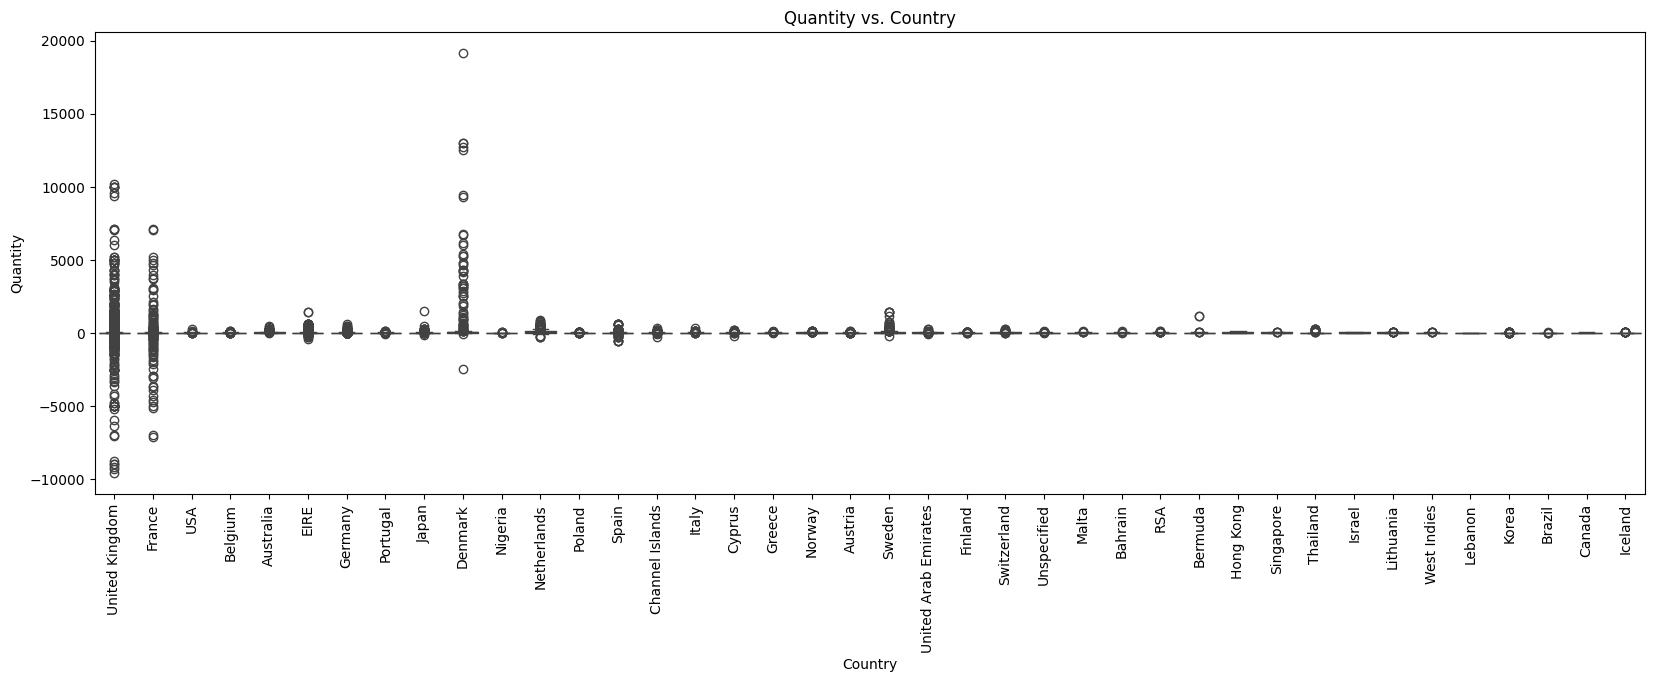

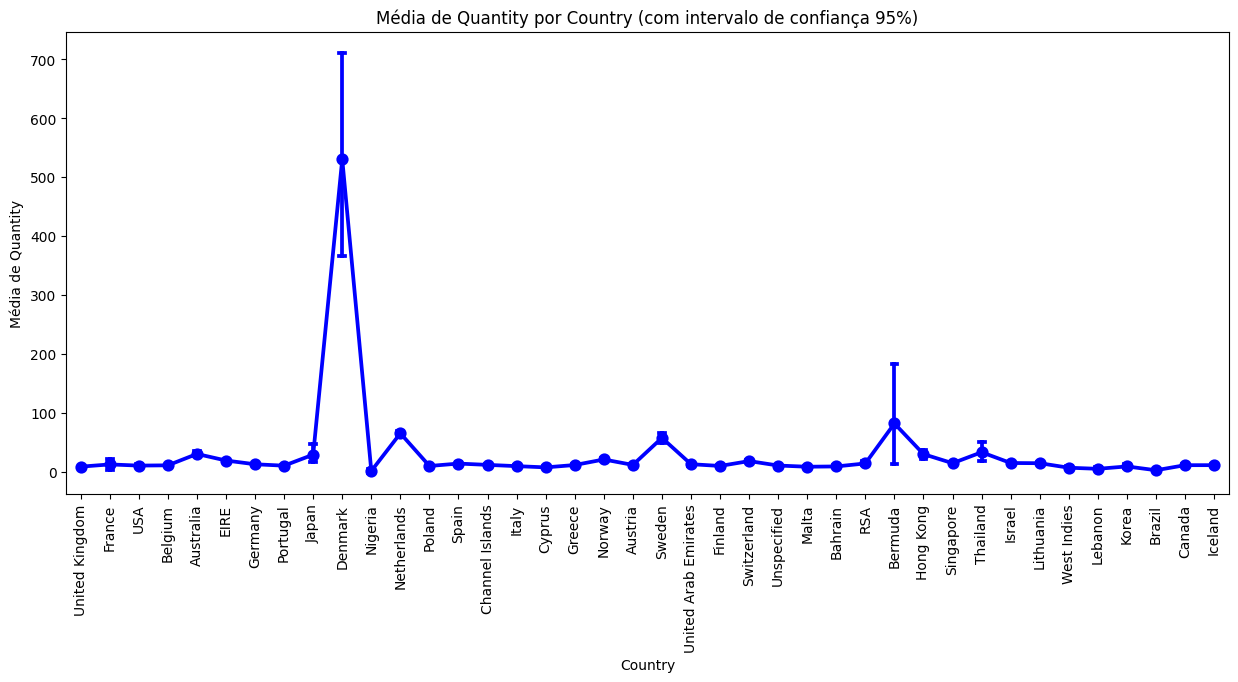

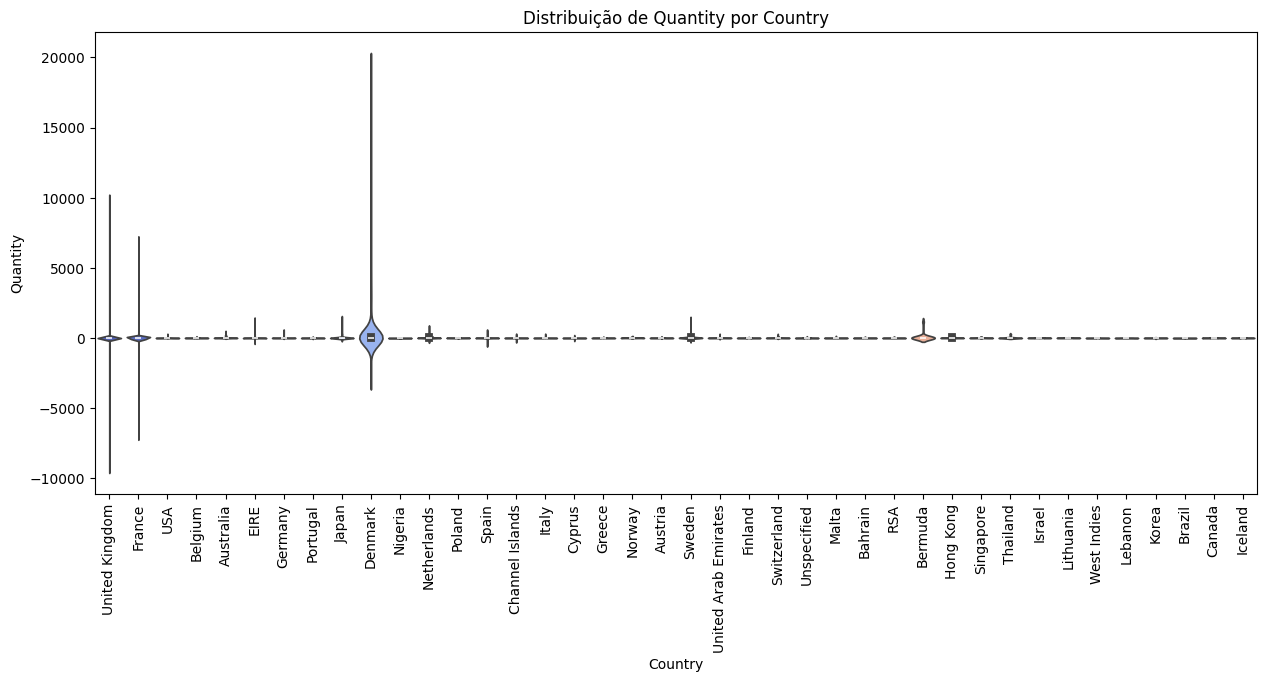

In [20]:
coluna_numerica = 'Quantity'

plot_boxplot(online_retail_data, 'Country', coluna_numerica)

plot_media_confidence(online_retail_data, 'Country', coluna_numerica)

plot_violinplot(online_retail_data, 'Country', coluna_numerica)

---

A an√°lise dos tr√™s gr√°ficos revela poss√≠veis viola√ß√µes das suposi√ß√µes da ANOVA para a vari√°vel **Quantity**. O **boxplot** evidencia alta dispers√£o e presen√ßa de outliers extremos em alguns pa√≠ses, como **United Kingdom, Denmark e Japan**, sugerindo poss√≠vel viola√ß√£o da homogeneidade das vari√¢ncias. O **gr√°fico de m√©dias com intervalo de confian√ßa** indica diferen√ßas significativas entre os pa√≠ses, mas tamb√©m mostra intervalos de confian√ßa muito amplos para alguns grupos, o que pode indicar alta variabilidade dentro das categorias. J√° o **violin plot** confirma distribui√ß√µes assim√©tricas e caudas longas para algumas categorias, apontando para poss√≠veis desvios da normalidade. 

---

#### 4.3.2) An√°lise `Price`

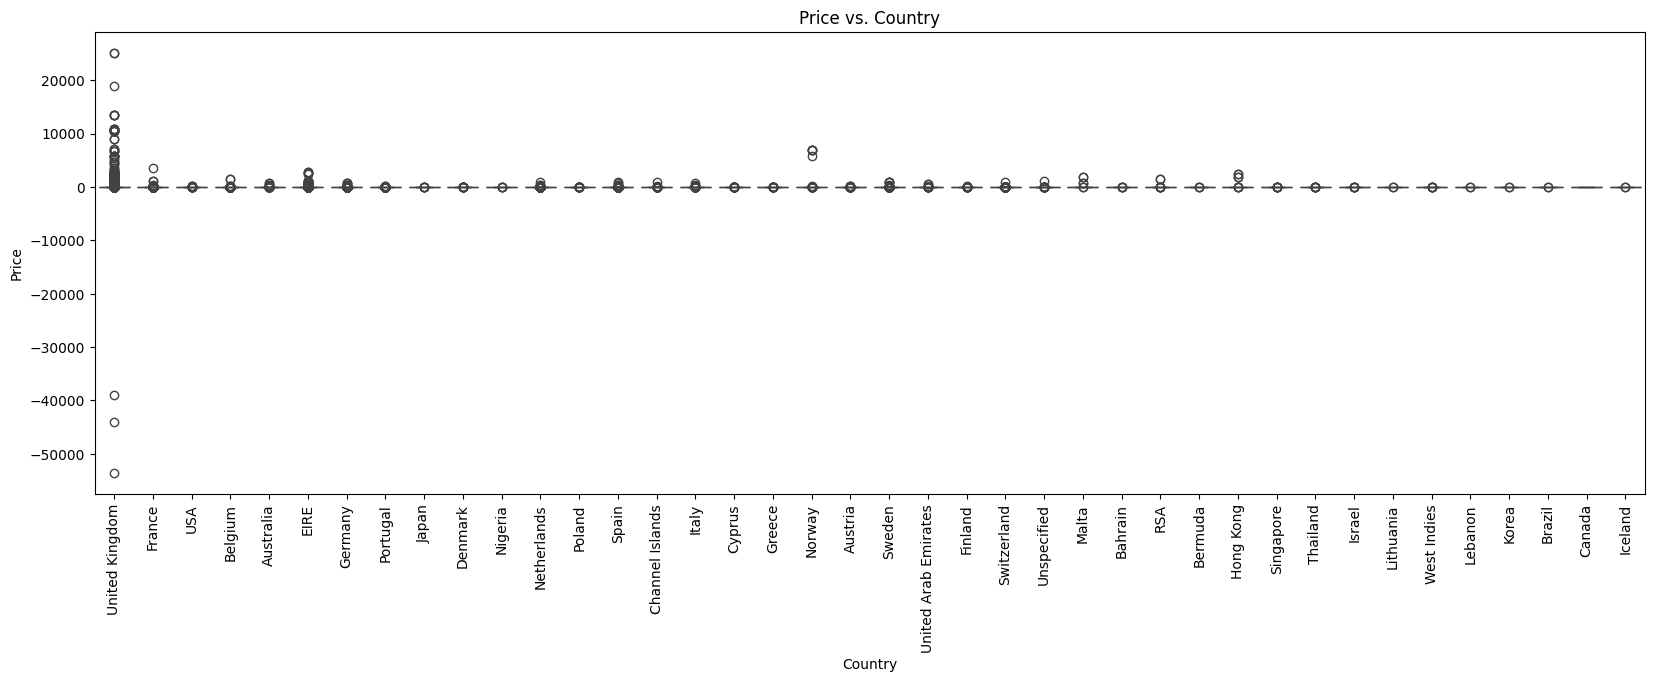

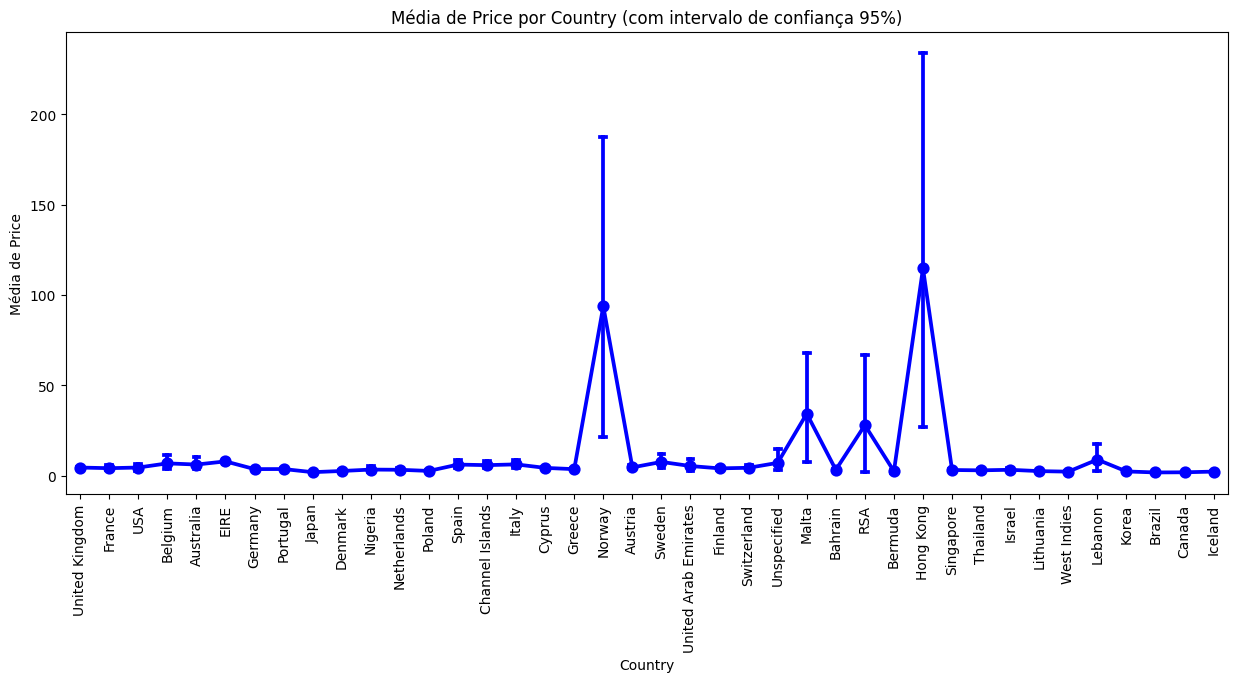

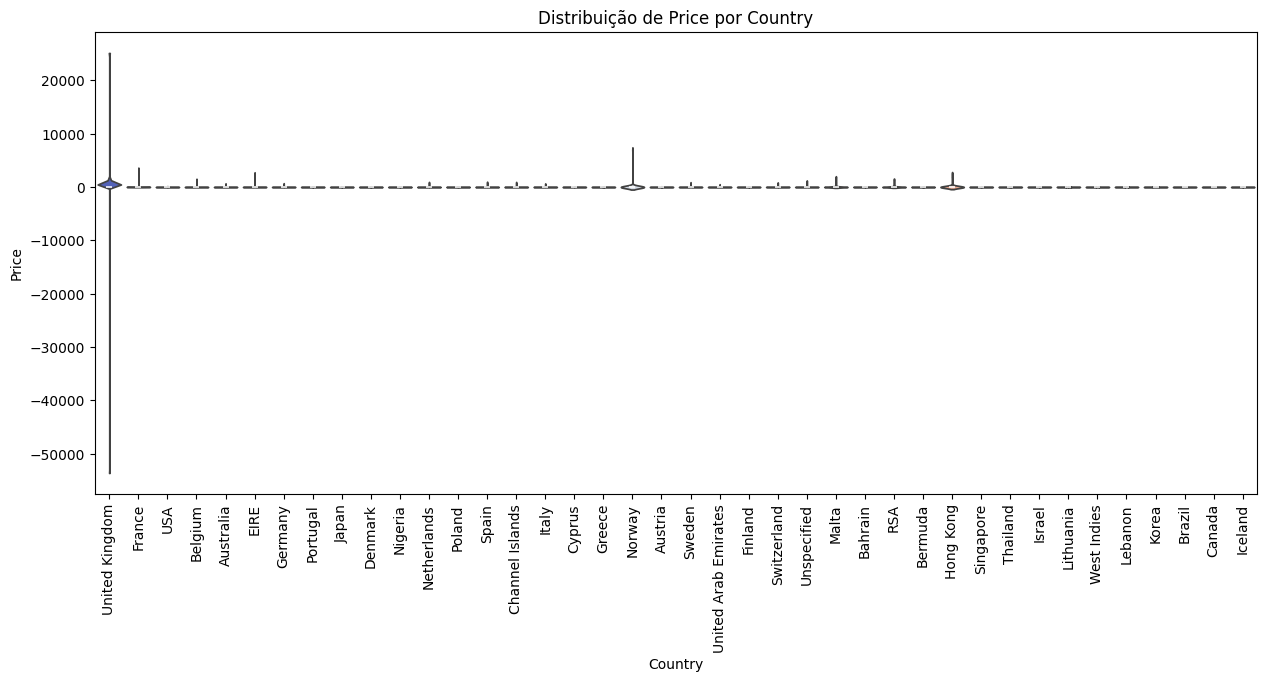

In [21]:
coluna_numerica = 'Price'

plot_boxplot(online_retail_data, 'Country', coluna_numerica)

plot_media_confidence(online_retail_data, 'Country', coluna_numerica)

plot_violinplot(online_retail_data, 'Country', coluna_numerica)

---

A an√°lise dos tr√™s gr√°ficos sugere poss√≠veis viola√ß√µes das suposi√ß√µes da ANOVA para a vari√°vel **Price**. O **boxplot** evidencia grande dispers√£o e presen√ßa de outliers extremos, especialmente em pa√≠ses como **United Kingdom, Norway e Hong Kong**, indicando poss√≠vel viola√ß√£o da homogeneidade das vari√¢ncias. O **gr√°fico de m√©dias com intervalo de confian√ßa** revela que alguns pa√≠ses apresentam m√©dias significativamente diferentes, mas com intervalos de confian√ßa muito amplos, o que pode indicar alta variabilidade dentro dos grupos. J√° o **violin plot** confirma distribui√ß√µes assim√©tricas e caudas longas para algumas categorias, sugerindo que a suposi√ß√£o de normalidade pode estar comprometida.

---

## 5) An√°lise ANOVA

### 5.1) An√°lise ANOVA

In [22]:
# Filtrando para manter apenas os pa√≠ses que aparecem mais de uma vez, pois a ANOVA precisa de pelo menos dois valores por grupo para funcionar.
valid_countries = online_retail_data['Country'].value_counts()
valid_countries = valid_countries[valid_countries > 1].index
filtered_df = online_retail_data[online_retail_data['Country'].isin(valid_countries)]

# Separar os dados por pa√≠s para Quantity e Price
quantity_groups = [filtered_df[filtered_df['Country'] == country]['Quantity'].dropna() for country in filtered_df['Country'].unique()]
price_groups = [filtered_df[filtered_df['Country'] == country]['Price'].dropna() for country in filtered_df['Country'].unique()]

# Realizar ANOVA para Quantity e Price
anova_quantity = stats.f_oneway(*quantity_groups)
anova_price = stats.f_oneway(*price_groups)

# Exibir resultados
print("ANOVA para Quantity:")
print(f"F = {anova_quantity.statistic:.4f}, p-valor = {anova_quantity.pvalue:.4e}")
print("\nANOVA para Price:")
print(f"F = {anova_price.statistic:.4f}, p-valor = {anova_price.pvalue:.4e}")


ANOVA para Quantity:
F = 292.1790, p-valor = 0.0000e+00

ANOVA para Price:
F = 5.0687, p-valor = 4.2828e-23


---

A an√°lise de vari√¢ncia (ANOVA) revelou diferen√ßas estatisticamente significativas tanto para a quantidade vendida (`Quantity`) quanto para o pre√ßo (`Price`) entre os pa√≠ses.  

- **ANOVA para Quantity**:  
  - **F = 292.1790**, **p-valor ‚âà 0**  
  - Forte varia√ß√£o entre os pa√≠ses na quantidade m√©dia vendida.  

- **ANOVA para Price**:  
  - **F = 5.0687**, **p-valor = 4.2828e-23**  
  - Diferen√ßas significativas nos pre√ßos m√©dios, mas com menor varia√ß√£o em rela√ß√£o √† quantidade.  

---

### 5.2) Verifica√ß√£o dos pressupostos ANOVA

---
#### 1. Normalidade dos Res√≠duos ‚Üí **Teste de Shapiro-Wilk**
- Avalia se os res√≠duos seguem uma distribui√ß√£o normal.
- Se o **p-valor > 0.05**, assumimos que os res√≠duos s√£o normalmente distribu√≠dos.

#### 2. Homocedasticidade (Igualdade de Vari√¢ncias) ‚Üí **Teste de Levene**
- Verifica se as vari√¢ncias dos grupos s√£o aproximadamente iguais.
- Se o **p-valor > 0.05**, assumimos que as vari√¢ncias s√£o homog√™neas.

#### 3. Independ√™ncia dos Dados
- A ANOVA assume que as observa√ß√µes s√£o **independentes entre si**.
- Esse pressuposto depende do processo de coleta dos dados e deve ser garantido pelo pesquisador.

---


Teste de Normalidade (D‚ÄôAgostino-Pearson):
Quantity: p-valor = 0.0000e+00
Price: p-valor = 0.0000e+00

Teste de Homocedasticidade (Levene):
Quantity: W = 299.4525, p-valor = 0.0000e+00
Price: W = 5.0214, p-valor = 9.0746e-23


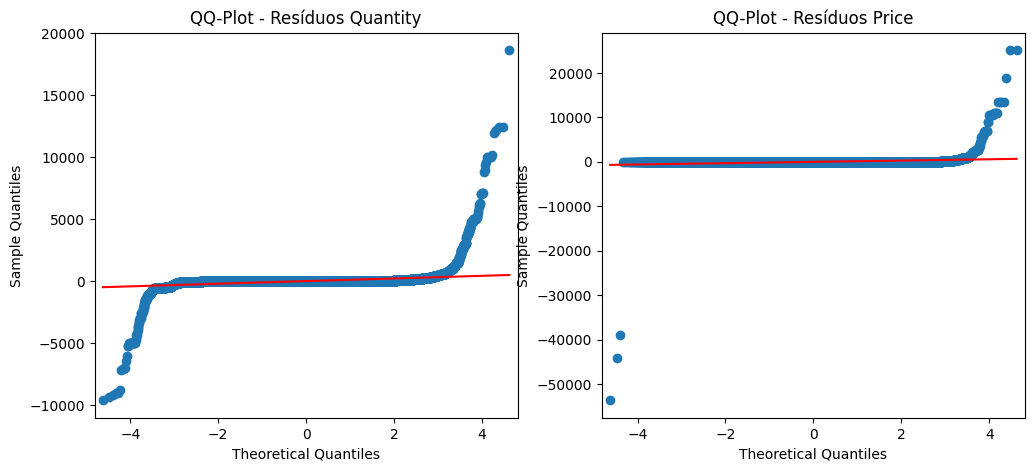

In [23]:
validar_pressupostos_anova(quantity_groups, price_groups, filtered_df)

---

**1. Teste de Normalidade (D‚ÄôAgostino-Pearson)**
- Como a amostra analisada possui 525.461 observa√ß√µes, o **teste de Shapiro-Wilk** n√£o se mostrou confi√°vel uma vez que sua utiliza√ß√£o √© recomendada para amostras de at√© 5.000 observa√ß√µes, portanto, utilizou-se o **teste de normalidade D‚ÄôAgostino-Pearson**. Ao combinar assimetria (skewness) e curtose (kurtosis) para verificar desvios da normalidade, se torna mais adequado para grandes amostras.
- Quantity: p-valor = 0.0000
- Price: p-valor = 0.0000

Os p-valores s√£o muito pequenos (menores que 0.05), o que indica que os res√≠duos n√£o seguem uma distribui√ß√£o normal.

**2. Teste de Homocedasticidade (Levene)**
- Quantity: W = 299.4525, p-valor = 0.0000
- Price: W = 5.0214, p-valor = 9.0746e-23

Os p-valores muito pequenos sugerem que as vari√¢ncias n√£o s√£o homog√™neas entre os grupos, indicando uma viola√ß√£o do pressuposto de homocedasticidade.

**3. QQ-Plots dos Res√≠duos**
Os gr√°ficos **QQ-Plot** ajudam a visualizar a normalidade dos res√≠duos:

- Quantity: Os pontos se afastam significativamente da linha te√≥rica, especialmente nas extremidades.
- Price: Os pontos tamb√©m mostram desvios not√°veis em rela√ß√£o √† normalidade.

---

### 5.3) Ajuste do modelo

In [24]:
ajustar_modelo(filtered_df)


Teste de Kruskal-Wallis:
Quantity: H = 21615.2682, p-valor = 0.0000e+00
Price: H = 1454.1417, p-valor = 5.5543e-280

Modelo de Regress√£o - Log(Quantity):
                 Generalized Linear Model Regression Results                  
Dep. Variable:           Log_Quantity   No. Observations:               525461
Model:                            GLM   Df Residuals:                   525421
Model Family:                Gaussian   Df Model:                           39
Link Function:               Identity   Scale:                          1.0048
Method:                          IRLS   Log-Likelihood:            -7.4682e+05
Date:                Sun, 09 Feb 2025   Deviance:                   5.2792e+05
Time:                        18:46:08   Pearson chi2:                 5.28e+05
No. Iterations:                     3   Pseudo R-squ. (CS):            0.04623
Covariance Type:            nonrobust                                         
                                      coef    std err 

---

**1. Teste de Kruskal-Wallis**
- **Quantity: H = 21615.2682, p-valor = 0.0000**
- **Price: H = 1454.1417, p-valor = 5.5543e-280**

Os resultados indicam que h√° **diferen√ßas estatisticamente significativas** entre os pa√≠ses tanto para `Quantity` quanto para `Price`. Isso confirma que os pa√≠ses possuem distribui√ß√µes de quantidade e pre√ßo diferentes.

**2. Modelo de Regress√£o - Log(Quantity)**
- Diversos pa√≠ses apresentam coeficientes **estatisticamente significativos** (p-valor < 0.05), sugerindo varia√ß√£o na quantidade m√©dia vendida entre pa√≠ses.
- Alguns pa√≠ses possuem coeficientes **negativos**, indicando que a quantidade m√©dia vendida √© menor em compara√ß√£o com a refer√™ncia (`Intercept`).
- O **pseudo R¬≤ = 0.04623** indica que o modelo explica apenas **4.6% da varia√ß√£o** em `Log_Quantity`, sugerindo que outros fatores influenciam as quantidades vendidas.

**3. Modelo de Regress√£o - Log(Price)**
- Para `Log_Price`, alguns pa√≠ses apresentam coeficientes **estatisticamente significativos**, enquanto outros n√£o.
- O **pseudo R¬≤ = 0.001985**, ou seja, o modelo **explica menos de 0.2% da varia√ß√£o** no pre√ßo, indicando que `Country` tem **pouca influ√™ncia** na varia√ß√£o de pre√ßo.

---

**Resumo**
- As diferen√ßas entre os pa√≠ses s√£o **estatisticamente significativas** para `Quantity` e `Price`, conforme o **teste de Kruskal-Wallis**.
- O modelo de regress√£o para `Log_Quantity` sugere que **alguns pa√≠ses t√™m quantidades m√©dias significativamente diferentes**.
- O modelo de regress√£o para `Log_Price` sugere que o pa√≠s **tem pouca influ√™ncia na varia√ß√£o de pre√ßos**.
- O **baixo R¬≤ nos modelos** indica que **outros fatores al√©m do pa√≠s afetam as vendas**.

---

## 6) Tomada de decis√£o

---

**Decis√µes Estrat√©gicas Baseadas nos Resultados**

**1. Personaliza√ß√£o de Pre√ßos por Mercado**

üîπ **Precifica√ß√£o din√¢mica baseada na demanda** ‚Üí A empresa pode **ajustar os pre√ßos em mercados onde os consumidores est√£o dispostos a pagar mais** e oferecer **descontos onde a sensibilidade ao pre√ßo for alta**.  
üîπ **Modelos preditivos mais robustos** ‚Üí Explorar **modelos de Machine Learning** para entender **outros fatores que impactam o pre√ßo**.

**2 Estrat√©gia de Estoque e Distribui√ß√£o**

üîπ **Realocar estoques para pa√≠ses com maior demanda** ‚Üí Como Dinamarca e Holanda apresentaram alto impacto positivo, esses mercados devem receber **prioridade na aloca√ß√£o de produtos**.  
üîπ **Reduzir riscos em mercados com baixa demanda** ‚Üí Em pa√≠ses como Brasil e Nig√©ria, pode-se **testar campanhas promocionais** antes de comprometer grandes estoques.

**3 Estrat√©gia de Marketing Regional**

üîπ **Promo√ß√µes agressivas em mercados com vendas baixas** ‚Üí Campanhas espec√≠ficas podem ser direcionadas para **est√≠mulo da demanda em mercados como Brasil e L√≠bano**.  
üîπ **Destaque de diferenciais em mercados premium** ‚Üí Para mercados onde os clientes pagam mais, √© poss√≠vel **refor√ßar o posicionamento premium do produto**.

**4 Expans√£o e Investimento**

üîπ **Expandir para pa√≠ses com maior potencial de vendas** ‚Üí Focar investimentos em **pa√≠ses onde a demanda e os pre√ßos s√£o mais favor√°veis**.  
üîπ **Evitar investimentos excessivos em mercados de baixa performance**, a menos que **mudan√ßas estrat√©gicas sejam aplicadas** para melhorar a aceita√ß√£o do produto.


**Conclus√£o Final**
- Os resultados indicam que a estrat√©gia de vendas deve ser adaptada para diferentes mercados, considerando a varia√ß√£o de demanda e sensibilidade ao pre√ßo. 
- O modelo de `Log(Quantity)` sugere que fatores locais impactam fortemente as vendas, e ajustes estrat√©gicos devem ser feitos por pa√≠s. 
- O modelo de `Log(Price)` mostra que a precifica√ß√£o precisa ser mais din√¢mica e considerar fatores al√©m da localiza√ß√£o.

---